<a href="https://colab.research.google.com/github/Seyi85/Natural_language_processsing/blob/main/2_Exercise_LM_of_IMDb_(Fastai).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune a Langage Model with Fast.ai
Notebook based on:
- https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb
- https://github.com/fastai/course-nlp/blob/master/5-nn-imdb.ipynb

Video:
- https://www.youtube.com/watch?v=WjnwWeGjZcM (From 0:00 to 55:00)

#### Get latest Fast.ai version (without installing the Pytorch dependency)

In [1]:
!pip install --upgrade --no-deps fastai
!pip install --upgrade --no-deps fastcore

     |████████████████████████████████| 194kB 8.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 61kB 4.9MB/s 


#### Imports

In [2]:
from fastai.text.all import * # We need fastai version 2 for this
from pathlib import Path

#### Check GPU usage

In [3]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("WARNING: Not GPU detected")

Using GPU: Tesla T4


# Get data

In [4]:
CLOUD = True

In [5]:
if CLOUD:
    # Download the data from internet
    # If you are using cloud platforms
    # like Google Colab or Kaggle kernels
    data_path = untar_data(URLs.IMDB)
else:
    # Point to the path where the data is
    # located at your local machine
    data_path = Path("../../Datasets/NLP/IMBd")
    
print("Dataset is loacted at:", data_path)

Dataset is loacted at: /root/.fastai/data/imdb


In [6]:
print("Train:", len(list( (data_path/"train").glob('**/*.txt') )), "reviews")
print("Test: ", len(list( (data_path/"test").glob('**/*.txt')  )), "reviews")
print("Unsup:", len(list( (data_path/"unsup").glob('**/*.txt') )), "reviews")

Train: 25000 reviews
Test:  25000 reviews
Unsup: 50000 reviews


# Dataset

In [7]:
files = get_text_files(data_path, folders = ['train', 'test', 'unsup'])
files

(#100000) [Path('/root/.fastai/data/imdb/test/pos/942_10.txt'),Path('/root/.fastai/data/imdb/test/pos/3967_9.txt'),Path('/root/.fastai/data/imdb/test/pos/3893_8.txt'),Path('/root/.fastai/data/imdb/test/pos/453_9.txt'),Path('/root/.fastai/data/imdb/test/pos/4033_8.txt'),Path('/root/.fastai/data/imdb/test/pos/6163_8.txt'),Path('/root/.fastai/data/imdb/test/pos/2399_10.txt'),Path('/root/.fastai/data/imdb/test/pos/12266_7.txt'),Path('/root/.fastai/data/imdb/test/pos/11109_7.txt'),Path('/root/.fastai/data/imdb/test/pos/1932_10.txt')...]

In [8]:
txt = files[0].open().read()
txt[:75]

'The Australian public and the Australian film industry are often heard to c'

## Dataloader

At every epoch:

1. **Shuffle** (sort randomly) our collection of texts.
2. **Concatenate** the individual texts together into a big stream. 
3. **Cut** this stream into a certain number of batches (which is our batch size).
   - For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens.
   
So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

- takes 5 mins for tokenization in Kaggle
- takes 1 mins for tokenization in local machine

In [9]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

imdb_dls_lm = DataBlock(
    blocks    = TextBlock.from_folder(data_path, is_lm=True),
    get_items = get_imdb,
    splitter  = RandomSplitter(0.1)
).dataloaders(data_path, path=data_path, bs=64, seq_len=80)

In [10]:
imdb_dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos yes i really said that , i ai n't into all that cgi superhero bull , i like all out action flicks like the mechanik , a brutal revenge movie with some of the best action iv'e seen for years . xxmaj dolph lundgren is a xxunk in this and made me remember how much i love him sure he was never as big a star as most of the action hero 's of the 80 's but as","yes i really said that , i ai n't into all that cgi superhero bull , i like all out action flicks like the mechanik , a brutal revenge movie with some of the best action iv'e seen for years . xxmaj dolph lundgren is a xxunk in this and made me remember how much i love him sure he was never as big a star as most of the action hero 's of the 80 's but as he"
1,"promising career . xxmaj as long as she keeps making more movies such as "" the xxmaj good xxmaj girl "" ( in which she 's terrific ) and less like "" along xxmaj came xxmaj polly , "" she 'll have a career of which she could be proud . \n\n xxmaj aniston tries desperately to overcome the limp material with which she 's working , but it 's a daunting task for any actress . xxmaj with the","career . xxmaj as long as she keeps making more movies such as "" the xxmaj good xxmaj girl "" ( in which she 's terrific ) and less like "" along xxmaj came xxmaj polly , "" she 'll have a career of which she could be proud . \n\n xxmaj aniston tries desperately to overcome the limp material with which she 's working , but it 's a daunting task for any actress . xxmaj with the exception"


In [11]:
print(imdb_dls_lm.vocab[:100])

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', '"', "'s", '-', 'was', '\n\n', 'as', 'with', 'for', 'movie', 'but', 'film', 'you', ')', 'on', "n't", '(', 'not', 'are', 'he', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', '!', 'there', 'or', 'just', 'her', 'do', 'about', 'has', 'out', "'", 'if', 'what', 'some', '?', 'good', 'when', 'more', 'very', 'she', 'up', 'would', 'no', '…', 'time', 'even', 'my', 'can', 'their', 'which', 'only', 'story', 'really', 'see', 'had', 'were', 'did', 'me', 'well', 'we', 'does', 'than', 'much', ':', 'could', 'bad', 'get']


In [12]:
len(imdb_dls_lm.vocab)

60008

# Create the Fastai learner (dataloader + model + loss)

In [13]:
learn = language_model_learner(
    dls       = imdb_dls_lm,
    arch      = AWD_LSTM,
    drop_mult = 0.3, 
    metrics   = [accuracy, Perplexity()],
    cbs       = [ShowGraphCallback]
).to_fp16()

### Text Generation BEFORE FINETUNNNG WITH IMDB (Just for fun :D)

In [14]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

The Doctor Who Meets Me = = = a Doctor Who Story ( also known as The Phantom Menace ) is a 2011 British science fiction action - adventure film

The Spider - Man : The Movie Trailer by Michael Jackson , Inc . , Universal Pictures , CEO and Young Artist Studio , Film

The American Civil War = a civil war , lasting from August 19 , 1899 to February 4 , 1950 , in the American Civil War . The war was pro -

The Velvet Revolver was released in France on 19 February 1993 . The album is an anthology of rock and roll , as well as a range of musical styles . The album features a

The Harry Potter and the Deathly Hallows – Part 2 , the seventh film in the series , was first released in the UK on 20 December 2011 . The Harry


## Fine-Tuning the Language Model with IMDB
- This takes 24:46 mins on GTX 1080ti 11GB
- This takes 27:48 mins on Tesla P100 16GB (Kaggle GPU)
- This takes ~22mins mins on Tesla T4 (Colab GPU)
- This takes >30mins mins on Tesla K80 (Colab GPU)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.033856,3.914391,0.299283,50.118519,23:04


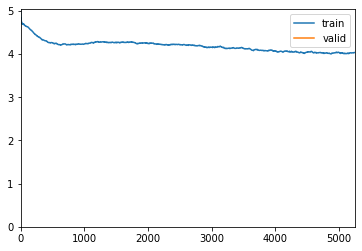

In [15]:
learn.fit_one_cycle(1, 2e-2)

### Saving and Loading Models
You can easily save the state of your model like so:

In [16]:
learn.save('IMDb_LM_1epoch_frozen')

Path('/root/.fastai/data/imdb/models/IMDb_LM_1epoch_frozen.pth')

In [17]:
learn.path

Path('/root/.fastai/data/imdb')

This will create a file in `learn.path/models/` named *IMDb_LM_1epoch_frozen.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [18]:
learn = learn.load('IMDb_LM_1epoch_frozen')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

In [19]:
#learn.unfreeze()
#learn.fit_one_cycle(10, 2e-3)

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [20]:
learn.save_encoder('finetuned_IMDb_LM')

> jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as _body_ when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Text Generation AFTER FINETUNNNG WITH IMDB (Just for fun :D)
Before we move on to fine-tuning the classifier, let's quickly try something different: using our model to generate random reviews. Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [21]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

The first two films i saw in France were The Adventures of Don Juan ( the film itself ) and The Adventures of Don Juan ( the Great Adventures of

The New York Times reporter ( i Dench ) , joe Keller ( the head of the New York City Homicide ( L.A . Confidential ) ) comes to

The movie I 've seen my TV show The Grudge , i have seen this movie in the past 5 years , but i thought it was a Great Movie , and i would not

The Nation of New York , United Kingdom , England , England , England , England , Wales and Sweden , many Americans are living elsewhere and have been

The fight in the Battle of Stalingrad and the battle of Stalingrad is one of the better - made movies of recent times . The best part of the film is to see a modern Soviet


In [22]:
TEXT        = "I liked this movie because"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

i liked this movie because i was so impressed by it . The story was fairly slow , but was boring . 

 While Boats was a little above average , the plot was just what it was about . i have

i liked this movie because it was a completely different story . i enjoyed I 'm looking forward to seeing Casablanca being viewed as a serious film in Europe . It is one of the few movies that is so near

i liked this movie because i enjoyed it , but i thought it was going to be a great movie , and i caught it on a channel in Europe one night , and i came to see it ! Like this movie

i liked this movie because of similarities to the film The Boogens , that followed the movie 's plot . i think this was also the best movie i have seen . I 've never seen a Crow movie before but

i liked this movie because there is a lot more of a classic movie than a remake . The soundtrack was originally recorded by Edmund Nash and i CA n't BLAME me for John Lennon 's decision to


As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalizes properly (*I* is just transformed to *i* because our rules require two characters or more to consider a word as capitalized, so it's normal to see it lowercased) and is using consistent tense. The general review makes sense at first glance, and it's only if you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

# <center> END
<center> We have fintuned the Language Model with the IMDb dataset.
<center> The next step is using that model to train a classifier.